## Imports and constants

In [3]:
%matplotlib ipympl

import os
import numpy as np
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy import signal
import matplotlib.pyplot as plt

from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.analysis.fitter import Fitter
from onix.helpers import data_identifier, console_bold, present_float
from onix.units import Q_, ureg

from tqdm import tqdm

In [4]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [5]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

## Setup

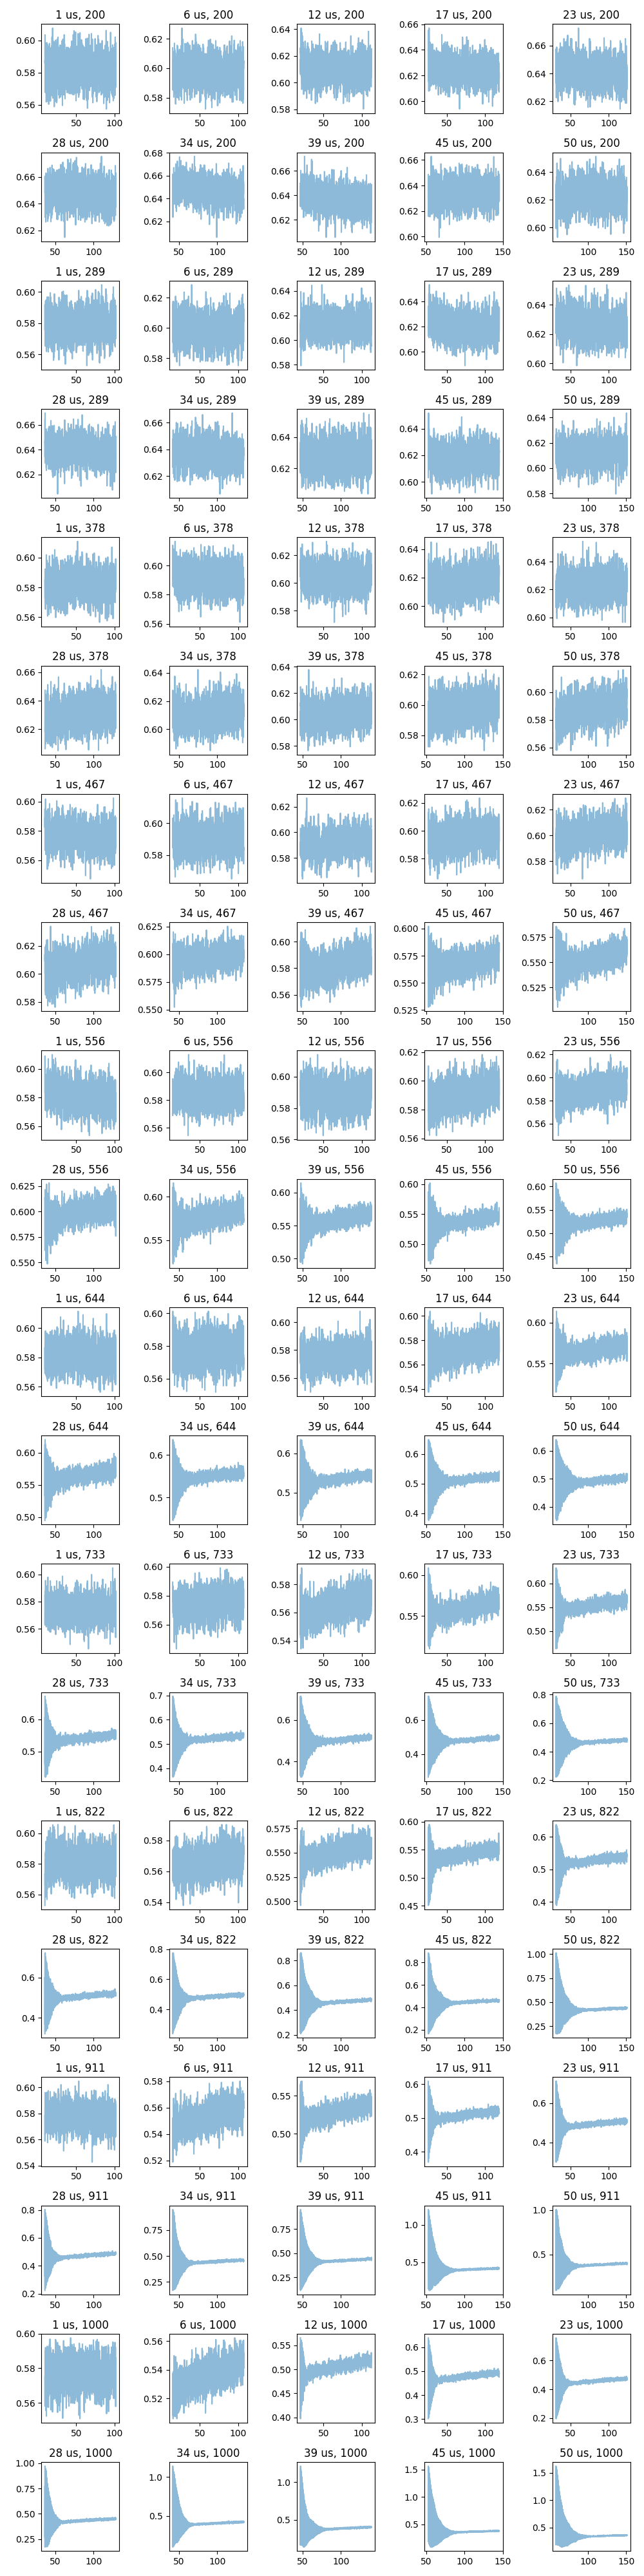

In [33]:
fig, ax = plt.subplots(20, 5, figsize=(10, 40))
for data_number in range(2161817, 2161917):
    index = data_number - 2161817
    #data_number = 2161846  # 1745558
    data, header = get_experiment_data(data_number)
    fid_params = header["params"]["detect"]["fid"]
    start_time = (fid_params["pump_time"] + fid_params["wait_time"]).to("s").magnitude + 7e-6
    for kk in range(len(data["transmissions_avg"])):
        times = np.arange(len(data["transmissions_avg"][kk])) / header["params"]["digitizer"]["sample_rate"]
        mask = times > start_time
        ax.flatten()[index].plot(times[mask] * 1e6, data["transmissions_avg"][kk][mask], label=data_number, alpha=0.5)
        ax.flatten()[index].set_title(f"{fid_params['pump_time'].to("us").magnitude:.0f} us, {fid_params['pump_amplitude']:.0f}")
    
# ax.set_xlabel("time (us)")
# ax.set_ylabel("voltage (V)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_586630/3091858288.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


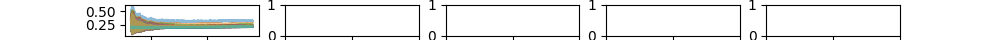

In [70]:
## 25e6 sampling range
data_range = range(2162329, 2162428+1) # NO RF

data_range = range(2162604, 2163183+1) # RF
# data_range = range(2163184, 2163623+1) # next ones
data_range = range(2168042, 2168143) #last ones

data_range = range(2168148, 2168149)
N = len(data_range)
fig, ax = plt.subplots(N//5+1, 5, figsize=(10, 40*N/100))
axx = ax.flatten()
for data_number in data_range:
    index = data_number - data_range[0]
    #data_number = 2161846  # 1745558
    data, header = get_experiment_data(data_number)
    fid_params = header["params"]["detect"]["fid"]
    start_time = (fid_params["pump_time"] + fid_params["wait_time"]).to("s").magnitude + 7e-6
    for kk in range(len(data["transmissions_avg"])):
        times = np.arange(len(data["transmissions_avg"][kk])) / header["params"]["digitizer"]["sample_rate"]
        mask = times > start_time
        axx[index].plot(times[mask] * 1e6, data["transmissions_avg"][kk][mask], label=data_number, alpha=0.5)
        axx[index].set_title(f"{data_number}")
    
# ax.set_xlabel("time (us)")
# ax.set_ylabel("voltage (V)")
plt.tight_layout()
plt.show()

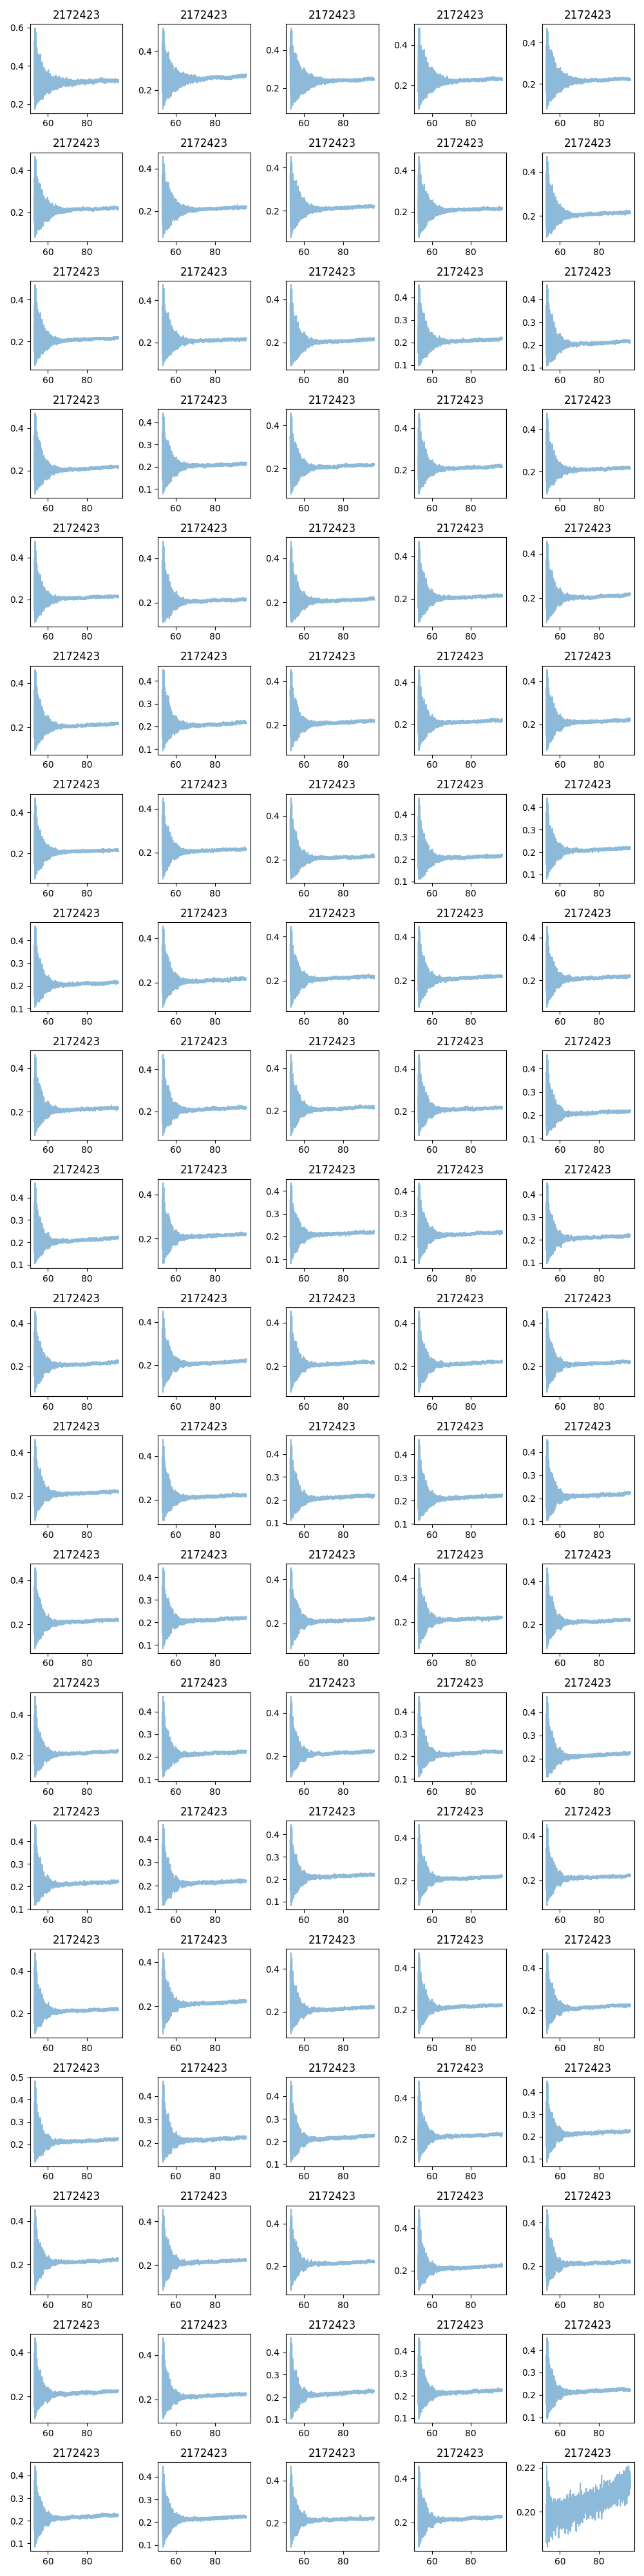

In [5]:

data_range = range(2172269, 2172270) # 10 s

data_range = range(2172423, 2172424) # 1s

N = len(data_range)
fig, ax = plt.subplots(20, 5, figsize=(10, 40))
axx = ax.flatten()
for data_number in data_range:
    index = data_number - data_range[0]
    #data_number = 2161846  # 1745558
    data, header = get_experiment_data(data_number)
    fid_params = header["params"]["detect"]["fid"]
    start_time = (fid_params["pump_time"] + fid_params["wait_time"]).to("s").magnitude + 7e-6
    for kk in range(len(data["transmissions_avg"])):
        times = np.arange(len(data["transmissions_avg"][kk])) / header["params"]["digitizer"]["sample_rate"]
        mask = times > start_time
        axx[kk].plot(times[mask] * 1e6, data["transmissions_avg"][kk][mask], label=data_number, alpha=0.5)
        axx[kk].set_title(f"{data_number}")
    
# ax.set_xlabel("time (us)")
# ax.set_ylabel("voltage (V)")
plt.tight_layout()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 953/953 [00:07<00:00, 128.54it/s]


2.2002778639310865


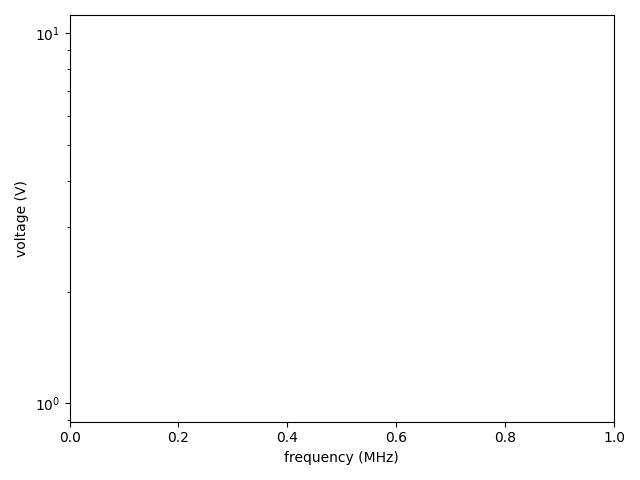

In [20]:

 # 0.01 s  ::  (2180870, 2180878) -> (2189438, 2189446)
 # 0.05 s  ::  (2192662, 2192670) -> (2200366, 2200374)
 # 0.1  s  ::  (2175006, 2175014) -> (2180854, 2180862)
 # 0.5  s  ::  (2190591, 2190599) -> (2192652, 2192660)
 #  1   s  ::  (2172423, 2172431) -> (2175006, 2175014)
 #  5   s  ::  (2189453, 2189461) -> (2190578, 2190586)
 # 10   s  ::  (2172224, 2172232) -> (2172404, 2172412)

# first 20 [9.742, 19.1, 12.35, 15.5, 16.7, 7.67, 10.7]

# all [9.6, 7.16, 11.87, 10.05, 12.95, 16, 17.9]
# last 20 [8.24, 6.67, 11.1, 9.55, 12.35, 16.67, 17.21

snrs = []
fig, ax = plt.subplots()

for ll in tqdm(range(2180870, 2189446, 9)):
    temp = []
    data, header = get_experiment_data(ll)
    fid_params = header["params"]["detect"]["fid"]
    start_time = (fid_params["pump_time"] + fid_params["wait_time"]).to("s").magnitude + 7e-6
    for kk in [0, 20, 40, 60, 80]: #range(1len(data["transmissions_avg"])):
        times = np.arange(len(data["transmissions_avg"][kk])) / header["params"]["digitizer"]["sample_rate"]
        mask = times > start_time
        time_resolution = times[1] - times[0]
        duration = times[mask][-1] - times[mask][0]
        N = duration / time_resolution
        ys = 2 * np.fft.rfft(data["transmissions_avg"][kk][mask])[1:] / N
        fs = np.fft.rfftfreq(len(data["transmissions_avg"][kk][mask]), d=time_resolution)[1:]
        # ax.plot(fs, np.abs(ys))
        
        # temp.append(np.max(np.abs(ys[fs > 3e6]))/np.average(np.abs(ys)[fs > 2e7]))
        temp.append(np.max(np.abs(ys[fs > 6e6])))
        # print(temp)
    # print(temp)
    # snrs.append(np.average(temp))
    snrs.append(np.average(temp)/np.std(temp)/np.sqrt(len(temp)))
    # print(snrs)
print(np.average(snrs))

ax.set_xlabel("frequency (MHz)")
ax.set_ylabel("voltage (V)")
ax.set_yscale("log")
plt.tight_layout()
plt.show()

In [11]:
for i in range(0, 10, 9):
    print(i)

0
9
